# Lab 01 - Local Optimization
## Tasks
- Introduction to PyTorch - will be used throughout the course
- Introduction to autograd
- Implement gradient descent using autograd framework
- Optimize a simple quadrupole triplet

## Set up environment

In [1]:
!pip install git+https://github.com/uspas/2021_optimization_and_ml --quiet

You should consider upgrading via the '/home/vagrant/.pyenv/versions/3.7.2/envs/py3/bin/python -m pip install --upgrade pip' command.


In [2]:
%reset -f

import numpy as np
import matplotlib.pyplot as plt

#matplotlib graphs will be included in your notebook, next to the code:
%matplotlib inline

#import toy accelerator package
from uspas_ml.accelerator_toy_models import simple_lattices

import torch

## Introduction to PyTorch
PyTorch is a machine learning library which implements autograd functionality (more on this in a bit). It will be useful for creating and training surrogate models. Many function implemented in numpy for `ndarrays` are also implemented in PyTorch with the `torch.Tensor` class. Here we show some examples of using `torch.Tensor`.

In [3]:
data = [[1, 2],[3, 4]]
x_data = torch.tensor(data)

In [4]:
np_array = np.array(data)
x_np = torch.from_numpy(np_array)

In [5]:
x_ones = torch.ones_like(x_data) # retains the properties of x_data
print(f"Ones Tensor: \n {x_ones} \n")

x_rand = torch.rand_like(x_data, dtype=torch.float) # overrides the datatype of x_data
print(f"Random Tensor: \n {x_rand} \n")

Ones Tensor: 
 tensor([[1, 1],
        [1, 1]]) 

Random Tensor: 
 tensor([[0.3485, 0.7569],
        [0.7730, 0.1621]]) 



In [6]:
shape = (2,3,)
rand_tensor = torch.rand(shape)
ones_tensor = torch.ones(shape)
zeros_tensor = torch.zeros(shape)

print(f"Random Tensor: \n {rand_tensor} \n")
print(f"Ones Tensor: \n {ones_tensor} \n")
print(f"Zeros Tensor: \n {zeros_tensor}")

Random Tensor: 
 tensor([[0.7216, 0.5029, 0.7364],
        [0.6530, 0.0670, 0.8354]]) 

Ones Tensor: 
 tensor([[1., 1., 1.],
        [1., 1., 1.]]) 

Zeros Tensor: 
 tensor([[0., 0., 0.],
        [0., 0., 0.]])


In [7]:
tensor = torch.rand(3,4)

print(f"Shape of tensor: {tensor.shape}")
print(f"Datatype of tensor: {tensor.dtype}")
print(f"Device tensor is stored on: {tensor.device}")

Shape of tensor: torch.Size([3, 4])
Datatype of tensor: torch.float32
Device tensor is stored on: cpu


In [8]:
tensor = torch.ones(4, 4)
print('First row: ',tensor[0])
print('First column: ', tensor[:, 0])
print('Last column:', tensor[..., -1])
tensor[:,1] = 0
print(tensor)

First row:  tensor([1., 1., 1., 1.])
First column:  tensor([1., 1., 1., 1.])
Last column: tensor([1., 1., 1., 1.])
tensor([[1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.]])


In [9]:
t1 = torch.cat([tensor, tensor, tensor], dim=1)
print(t1)

tensor([[1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1.],
        [1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1.],
        [1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1.],
        [1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1.]])


In [10]:
# This computes the matrix multiplication between two tensors. y1, y2, y3 will have the same value
y1 = tensor @ tensor.T
y2 = tensor.matmul(tensor.T)

y3 = torch.rand_like(tensor)
torch.matmul(tensor, tensor.T, out=y3)


# This computes the element-wise product. z1, z2, z3 will have the same value
z1 = tensor * tensor
z2 = tensor.mul(tensor)

z3 = torch.rand_like(tensor)
torch.mul(tensor, tensor, out=z3)

tensor([[1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.]])

In [11]:
# This sums all the elements of a tensor
agg = tensor.sum()
agg_item = agg.item()
print(agg_item, type(agg_item))

12.0 <class 'float'>


In [12]:
# Add a scalar to all the elements of a tensor
print(tensor, "\n")
tensor.add_(5)
print(tensor)
tensor += 5
print(tensor)

tensor([[1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.]]) 

tensor([[6., 5., 6., 6.],
        [6., 5., 6., 6.],
        [6., 5., 6., 6.],
        [6., 5., 6., 6.]])
tensor([[11., 10., 11., 11.],
        [11., 10., 11., 11.],
        [11., 10., 11., 11.],
        [11., 10., 11., 11.]])


## A note regarding tensor shapes
Paying attention to the shape of your tensors/numpy arrays is important, especially if you don't have a lot of experience programming. In general ML algorithms accept 2D arrays where the shape is given by `(number_of_samples, dimension_of_samples)`. Even if the input parameter is 1D the input shape should be `(number_of_samples, 1)`. 

Furthermore it is important to remember that slicing along a single axis returns a 1D tensor/array ie. `x[:,0]` returns an array shape of `(n_samples,)`.

Functions that will be useful for manipulating the shape of a tensor/array:
- `.reshape()`
- `.unsqueeze()`
- `.squeeze()`
- `.flatten()`


## GPU Integration
To speed up many of the computations that we will do in this course we will move our data/models to a GPU. This works best when doing large matrix calculations or batch optimization routines. Keep in mind the time cost associated with moving data back and forth between a CPU and a GPU, this can slow down smaller scale calculations. 

In [13]:
# We move our tensor to the GPU if available
if torch.cuda.is_available():
    tensor = tensor.to('cuda')

## Autograd with PyTorch
Its hard to overstate the importance of Automatic Differentiation (commonly referred to Autograd) to the machine learning community. It forms the basis for training/optimizing surrogate models such as Gaussian Processes and Neural Networks.

Autograd is a framework for doing calculations while keeping track of the derivatives associated with each calculation step. We will then be able to calculate the total derivative of say, the beam size vs. a quadrupole strength parameter. This will be used to train surrogate models with derivative based optimization methods (gradient descent and its descendants).

Autograd works by creating what is known by a computational graph (an example of which is below). The graph has a set of what are known as leaf nodes (or tensors) $a,w_1,w_2,w_3,w_4$ which represent input variables that we choose. We wish to compute how changing these variables will effect the result $L$. Each of the lines on the computation graph represent a single calculation which we will need the derivate of to calculate the total derivative.
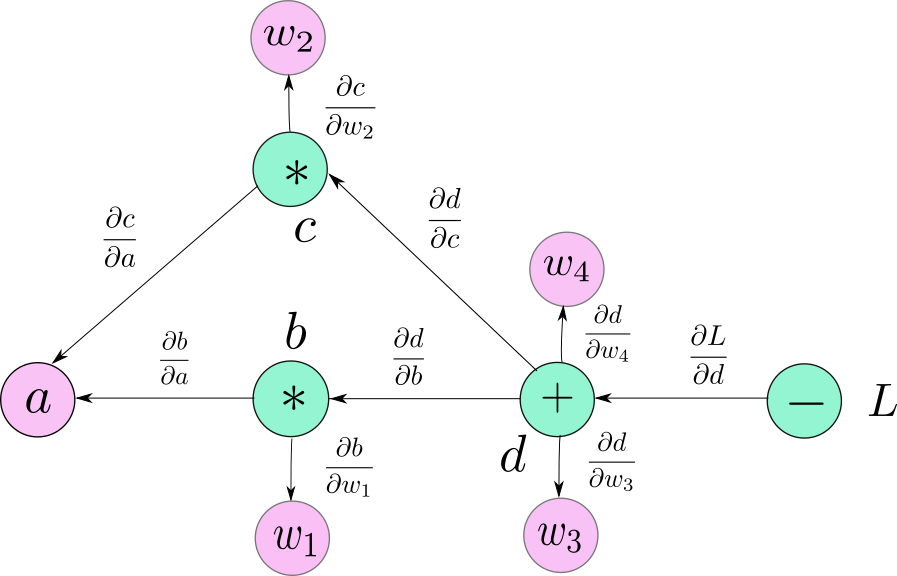

Our calculation will involve a number of discrete steps, each which create intermediate variables seen below:

$
\begin{align}
    b & = w_1 * a\\
    c & = w_2 * a\\
    d & = w_3*b + w_4*c\\
    L & = 10 -d
\end{align}
$

In order to calculate the total derivative of L with respect to say $w_1$ we use the chain rule

$$
\frac{dL}{dw_1} = \frac{\partial L}{\partial d}\frac{\partial d}{\partial b}\frac{\partial b}{\partial w_1}
$$

Using PyTorch the partial derivatives for each calculation are easily calculated for a wide variety of calculations and variable manipulations that we need for model building and programming. Furthermore, this is easily done with thousands of variables and/or manipulations at a time! Thanks PyTorch!

Lets take a look at how this can be done in practice. We start with defining some variables that we will need the derivatives with respect to by specifying `requires_grad = True` during creation.

In [14]:
#define variables (the chosen values here are arbitrary)
a = torch.tensor([2.], requires_grad=True)
w1 = torch.tensor([3.], requires_grad=True)
w2 = torch.tensor([1.], requires_grad=True)
w3 = torch.tensor([0.5], requires_grad=True)
w4 = torch.tensor([-2.], requires_grad=True)

#do the calculation
b = w1*a
c = w2*a
d = w3*b + w4*c
L = 10 - d

To calculate the derivatives we call `L.backward()`. After calling `backward()` the gradients are stored in the `.grad` attribute of each variable.

In [15]:
L.backward()
print(a.grad)
print(w4.grad)

tensor([0.5000])
tensor([-2.])


Note that we are calculating the gradient of $a$ and $w_4$ evaluated at their currently set values. In other words the grad attribute gives us

$$
\frac{dL}{da}\Big\rvert_{a = 2}
$$

<div class="alert alert-block alert-info">
    
**Task:** 
    Calculate (by hand) the quantity $\frac{dL}{dw_1}$, and check that this is consistent with the result given by `w1.grad`.
    
</div>

In [16]:
print(w1.grad) # Check that this is consistent with your analytical calculation

tensor([-1.])


Note that, if you redo the calculation a second time, the gradient will **accumulate**:

In [17]:
# redo the calculation a second time
b = w1*a
c = w2*a
d = w3*b + w4*c
L = 10 - d
# call backward to calculate the gradients a second time
L.backward()
# print gradient
print(w1.grad)

tensor([-2.])


If you want to avoid this, you can call `.grad.zero_()`

In [18]:
# zero the gradient
w1.grad.zero_()
# redo the calculation a third time
b = w1*a
c = w2*a
d = w3*b + w4*c
L = 10 - d
# call backward to calculate the gradients a third time
L.backward()
# print gradient
print(w1.grad)

tensor([-1.])


Note that you can also ask `pytorch` to temporarily stop tracking the gradients for certain operations:

In [19]:
with torch.no_grad():
    w1 = 2*w1

## Gradient descent

<div class="alert alert-block alert-info">
    
**Task:** 
    Now its your turn! Implement a gradient descent algortihm to minimize a simple test function below using autograd. Complete the implementation of the function `gradient_descent` below, to perform 100 iterations of gradient descent.

- implement the gradient descent algorithm using the above-mentioned features of pytorch
- record the values of `X0` as you go and generate a plot that shows how gradient descent travels through input space
- given the form of `test_function`, which value do you expect `X0` to converge to?
- redo the plot for 3 different values of the step size `alpha` [0.005, 0.1, 1.0 ]
    
</div>

In [20]:
def test_function(X):
    """
    Function to be optimized.
    
    Input: X, a pytorch tensor of shape (2,)
    Output: a single scalar
    """
    return (X[0] - 0.5)**2 + X[1]**2

def gradient_descent(X0, function, alpha=0.1, n_iterations=100):
    """
    Performs 100 iterations of gradient descent
    
    Inputs:
    X0: a pytorch tensor to be modified in-place by the gradient descent algorithm
    function: a callable, that takes X0 as input
    alpha: step size for the gradient descent algorithm
    n_iterations: number of iterations of gradient descent
    
    Returns:
    history_X: array of values of X
    history_f: array of values of f
    """
    history_X = []
    history_f = []
    for iteration in range(n_iterations): # iterations of gradient descent
        f = function(X0)
        
        # Your code that modifies X0 in-place here
        # ...
        
        # START SOLUTION
        f.backward()
        with torch.no_grad():
            X0 -= alpha*X0.grad
        X0.grad.zero_()
        # END SOLUTION
        
        # Keep a copy in history (do not modify these lines)
        history_X.append( X0.detach().numpy().copy() ) 
        history_f.append( f.detach().numpy().copy() )
        
    return np.array(history_X), np.array(history_f)

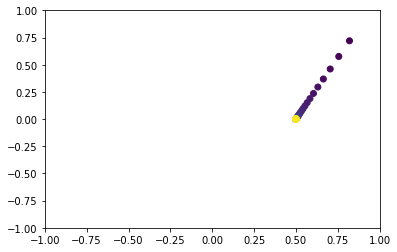

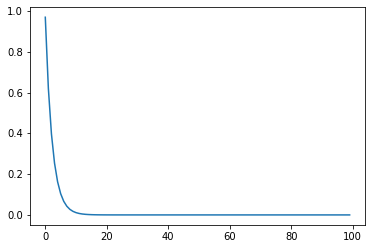

In [21]:
# Test your code by executing the code below
X0 = torch.tensor([0.9,0.9], requires_grad=True)
alpha = 0.1

history_X, history_f = gradient_descent( X0, test_function, alpha)

# Plot the trajectory of the points
plt.scatter( history_X[:,0], history_X[:,1], c=np.arange(len(history_X)))
plt.xlim(-1, 1)
plt.ylim(-1, 1)

plt.figure()
plt.plot(history_f)

## Accelerator example
Now we will use gradient descent to optimize the strengths of quadrupoles in a triplet configuration. 

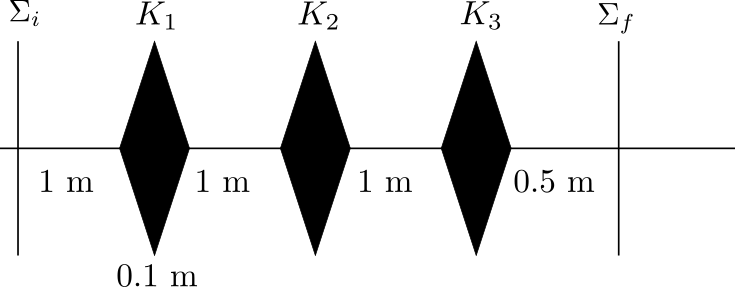


The function below creates a quadrupole triplet as defined in simple_lattices.py (see the accelerator toy models) and returns $\sqrt{\sigma_x^2 + \sigma_y^2}$ for an initial beam matrix defined in the function below.

Remember that the beam matrix takes the form of 

$
\Sigma = 
\begin{bmatrix}
\sigma_{11} & \sigma_{12} & \sigma_{13} & \sigma_{14} & \sigma_{15} & \sigma_{16} \\
\sigma_{21} & \sigma_{22} & \sigma_{23} & \sigma_{24} & \sigma_{25} & \sigma_{26} \\
\sigma_{31} & \sigma_{32} & \sigma_{33} & \sigma_{34} & \sigma_{35} & \sigma_{36} \\
\sigma_{41} & \sigma_{42} & \sigma_{43} & \sigma_{44} & \sigma_{45} & \sigma_{46} \\
\sigma_{51} & \sigma_{52} & \sigma_{53} & \sigma_{54} & \sigma_{55} & \sigma_{56} \\
\sigma_{61} & \sigma_{62} & \sigma_{63} & \sigma_{64} & \sigma_{65} & \sigma_{66} \\
\end{bmatrix}
$

where for example $\sigma_{11} = \sigma_x^2, \sigma_{12} = \sigma_{x,x'}$ etc.

We start with the following initial beam matrix.
$
\Sigma = 
\begin{bmatrix}
1e-6 & 0 & 0 & 0 & 0 & 0 \\
0 & 1e-8 & 0 & 0 & 0 & 0 \\
0 & 0 & 1e-6 & 0 & 0 & 0 \\
0 & 0 & 0 & 1e-8 & 0 & 0 \\
0 & 0 & 0 & 0 & 1e-8 & 0 \\
0 & 0 & 0 & 0 & 0 & 1e-8 \\
\end{bmatrix}
$

In [34]:
def beamsize(K , noise = 0.0):
    '''
    calculate sqrt(sigma_x^2 + sigma_y^2)
    
    K : magnetic strength of each quad magnet, torch.tensor, shape (3,)
    noise : rms noise level of measurement, float (default 0.0)
    
    Returns: the beam size in mm
    '''
    
    #generate initial beam matrix
    # - x/y/z geometric emittance of 1.0e-8 m-rad
    init_beam_matrix = torch.eye(6) * 1.0e-8

    #set x_rms beam size to 1 mm and rms divergence to 0.1 mrad
    init_beam_matrix[0,0] = 1.0e-3 ** 2 
    init_beam_matrix[1,1] = 1.0e-4 ** 2 
    init_beam_matrix[2,2] = 1.0e-3 ** 2 
    init_beam_matrix[3,3] = 1.0e-4 ** 2 
    
    #create accelerator lattice object with one quad and a drift
    line = simple_lattices.create_triplet(K.flatten())
    
    #propagate beam matrix
    final_beam_matrix = line.propagate_beam_matrix(init_beam_matrix, noise)
    return 1.e3*torch.sqrt(final_beam_matrix[0,0] + final_beam_matrix[2,2]) #Convert to mm

In [35]:
#example usage
K = torch.tensor([1.0, -1.0, 0.5], requires_grad = True)
print(K.requires_grad)
size = beamsize(K)
print(size)
size.backward()
print(K.grad)

True
tensor(1.4997, grad_fn=<MulBackward0>)
tensor([0.0003, 0.0005, 0.0002])


## Gradient Descent on the Accelerator Example

<div class="alert alert-block alert-info">
    
**Task:**
    Now apply gradient descent to optimizing the quadrupole strengths to minimize the total final beam size using the above function. Write the corresponding code below. (Feel free to reuse the function `gradient_descent` and to tune `alpha` and `n_iterations` to reach convergence - which you can assess by plotting the returned history ; do not hesitate to use a large value for `alpha`.)
    
What is the value of the beamsize that is obtained at the end of the optimization?
    
</div>

In [50]:
K = torch.tensor([10.0, -10.0, 5.0], requires_grad = True)
alpha = 100.0

history_X, history_f = gradient_descent(K, beamsize, alpha, n_iterations=3000)



**Your answer here:** (What is the value of the beamsize that is obtained at the end of the optimization?)

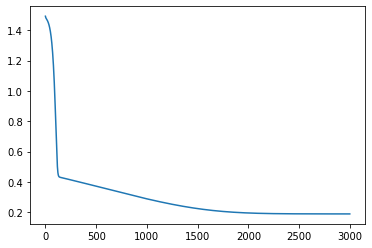

In [51]:
# START SOLUTION
plt.plot(history_f)
# END SOLUTION

## Gradient descent with numerical differentiation

<div class="alert alert-block alert-success">
    
**Homework:**
    Try to minimize again the beam size, but using numerical differentiation instead of autograd. In this case, you will **not** call the `.backward` and `.grad` functions, but instead you will need to calculate the gradient numerically: vary in the input `K` by `h=1.e-2` in each direction, in order to compute the gradient of `beam_size`.
    
(Note that, because we do not call `.backward`, we also do not need to set `requires_grad = True`.)
    
Does the algorithm reach the same final value, for the beamsize?
</div>

In [26]:
def gradient_descent_nd(X0, function, alpha=0.1, n_iterations=100):
    """
    Performs n_iterations iterations of gradient descent, 
    with numerical differentiation
    
    Inputs:
    X0: a pytorch tensor to be modified in-place by the gradient descent algorithm
    function: a callable, that takes X0 as input
    alpha: step size for the gradient descent algorithm
    n_iterations: number of iterations of gradient descent
    
    Returns:
    history_X: array of values of X
    history_f: array of values of f
    """
    history_X = []
    history_f = []
    for iteration in range(n_iterations): # iterations of gradient descent
        f = function(X0)
        
        # Your code that modifies X0 in-place here
        # ...
        
        # START SOLUTION
        h = 1.e-2
        grad = torch.zeros_like(X0)
        Xin = torch.zeros_like(X0)
        for i in range(len(X0)):
            Xin[:] = X0
            Xin[i] += h
            fi = function( Xin )
            grad[i] = (fi-f)/h
        X0 -= alpha*grad
        # END SOLUTION
        
        # Keep a copy in history (do not modify these lines)
        history_X.append( X0.detach().numpy().copy() ) 
        history_f.append( f.detach().numpy().copy() )
        
    return np.array(history_X), np.array(history_f)

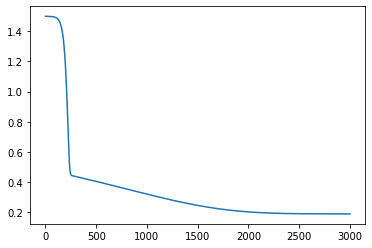

In [27]:
# START SOLUTION
K = torch.tensor([1.0, -1.0, 0.5])
history_X, history_f = gradient_descent_nd( K, beamsize, 1.e2, 3000)
plt.plot(history_f)
# END SOLUTIONa

**Your answer here:** (Does the algorithm reach the same value of `K`?)

In [28]:
# START SOLUTION
"""As expected, the algorithm reaches the same size at the end of the optimization (approximately 0.19 mm)."""
# END SOLUTION

'As expected, the algorithm reaches the same size at the end of the optimization (approximately 0.19 mm).'

## Gradient descent with noise

The function below emulates noise in the beam size measurement. 
Call this function several times for a given value of `K`. 

In [29]:
def beamsize_with_noise(K):
    return beamsize(K, noise=2.e-5)

In [30]:
# Call this function several times to get a sense of how much 
# the noise is changing the result
beamsize_with_noise(K)

tensor(0.1885)

<div class="alert alert-block alert-success">
    
**Homework:**
    Now perform the same optimization as before, but on the function `beam_size_with_noise` instead of `beam_size`. Does the analytical gradient descent reach approximately the same final value of the beamsize as before? Does the version of gradient descent with finite difference reach the same value too? Why? (Plot the history of the beamsize in both cases.) 
</div>

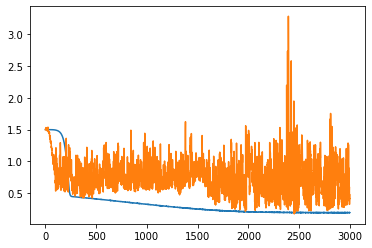

In [31]:
# Your code here

# START SOLUTION
K = torch.tensor([1.0, -1.0, 0.5], requires_grad = True)
history_X1, history_f1 = gradient_descent( K, beamsize_with_noise, 1.e2, n_iterations=3000 )

K = torch.tensor([1.0, -1.0, 0.5])
history_X2, history_f2 = gradient_descent_nd( K, beamsize_with_noise, 1.e2, n_iterations=3000 )

plt.plot( history_f1)
plt.plot( history_f2)
# END SOLUTION

**Your answer here:** (Does the analytical gradient descent reach approximately the same final value of the beamsize as before? Does the version of gradient descent with finite difference reach the same value too? Why?)

In [32]:
# START SOLUTION
"""With analytical differentiation, the beamsize reaches approximately the same 
value (0.19 mm). With numerical differentiation, the beamsize does converge to the 
same value. This is because numerical differentiation amplifies the noise when 
calculating the gradient (see the lecture slides) ; the gradient calculation is 
inaccurate and therefore gradient descent does not converge."""
# END SOLUTION

'With analytical differentiation, the beamsize reaches approximately the same \nvalue (0.19 mm). With numerical differentiation, the beamsize does converge to the \nsame value. This is because numerical differentiation amplifies the noise when \ncalculating the gradient (see the lecture slides) ; the gradient calculation is \ninaccurate and therefore gradient descent does not converge.'